### reference
 - https://publikationen.bibliothek.kit.edu/1000129520
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

In [1]:
# 基本ライブラリ
import base64
import gc
import glob
import io
import json
import os
import pathlib
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ディープラーニング用のライブラリ
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# データ前処理、拡張用のライブラリ
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset

# プログレスバーのライブラリ
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

# 画像処理用のライブラリ
import cv2
import imageio

# アノテーション用のライブラリ
import labelme

# セグメンテーション用のライブラリ
import segmentation_models_pytorch as smp

# warning設定
import sklearn.exceptions
from labelme import utils
from PIL import Image, ImageDraw

# 評価指標計算用のライブラリ
from sklearn.metrics import accuracy_score, f1_score

# データ分割のライブラリ
# 分割のライブラリ
from sklearn.model_selection import StratifiedKFold, train_test_split

warnings.filterwarnings("ignore")

In [2]:
# seedの固定
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# 画像のパスを取得
train_path = (
    "../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data"
)
train_files = sorted(glob.glob(os.path.join(train_path, "*.jpg")))
print(f"Train data: {len(train_files)}")

Train data: 1104


In [4]:
# アノテーションのパスを取得
train_label_path = "/workdir/practical-mi-guide/chapter3/input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/label"
train_labels = sorted(glob.glob(os.path.join(train_label_path, "*.json")))
print(f"Train label: {len(train_labels)}")

Train label: 394


In [5]:
# train_filesのうち.jpgを除いた部分がtrain_labelsのうち.jsonを除いた部分と一致するもののみを取得
train_files = [
    f
    for f in train_files
    if os.path.splitext(os.path.basename(f))[0]
    in [os.path.splitext(os.path.basename(l))[0] for l in train_labels]
]
print(f"Train data: {len(train_files)}")

Train data: 394


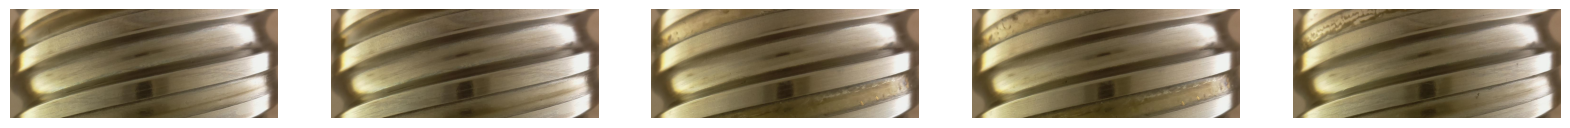

In [6]:
# train_filesの画像を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

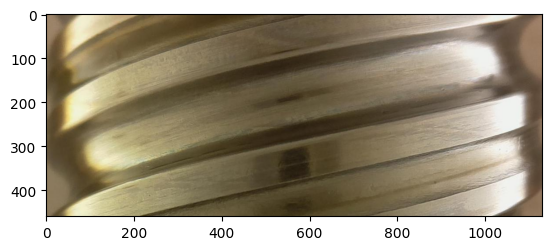

In [7]:
# reference:https://tanalib.com/labelme-json2image/

# jsonデータの読み込み
json_file = open(train_labels[0])
json_data = json.load(json_file)

# imageDataをkeyにしてデータを取り出す
img_b64 = json_data["imageData"]

# labelmeのutils関数を使ってbase64形式をPIL型に変換する
img_data = base64.b64decode(img_b64)
img_pil = utils.img_data_to_pil(img_data)

# 画像の可視化
plt.imshow(img_pil)
plt.show()

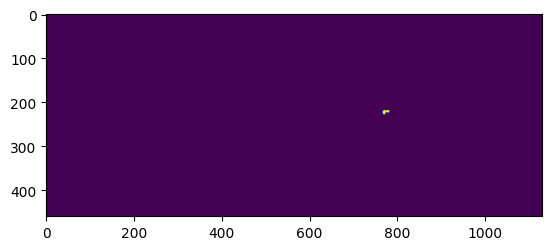

In [8]:
# reference:https://tanalib.com/labelme-json2image/

# アノテーションの頂点座標を取得
points = json_data["shapes"][0]["points"]  # 今回は画像中に1つだけ物体があることを想定
# list -> tuple
points = [tuple(point) for point in points]

# マスク画像を生成
w, h = img_pil.size
mask = Image.new("L", (w, h))
draw = ImageDraw.Draw(mask)
draw.polygon(points, fill=1)

# 画像の可視化
plt.imshow(mask)
plt.show()

In [9]:
# 上記をもとにして、画像とマスクを生成する関数を作成、画像中に複数の物体がある場合も考慮する
def create_mask_from_json(json_data, img_pil):
    # 画像サイズを取得
    w, h = img_pil.size
    # マスク画像を生成
    mask = Image.new("L", (w, h))
    draw = ImageDraw.Draw(mask)
    # マスク画像を生成するためのリスト
    mask_list = []
    # マスク画像を生成
    for shape in json_data["shapes"]:
        points = shape["points"]
        points = [tuple(point) for point in points]
        mask = Image.new("L", (w, h))
        draw = ImageDraw.Draw(mask)
        draw.polygon(points, fill=1)
        mask_list.append(mask)
    return mask_list

In [10]:
# train_labelsに対して上記の関数を適用
mask_list = []
train_list = []

for label in train_labels:
    json_file = open(label)
    json_data = json.load(json_file)
    img_b64 = json_data["imageData"]

    # labelmeのutils関数を使ってbase64形式をPIL型に変換する
    img_data = base64.b64decode(img_b64)
    img_pil = utils.img_data_to_pil(img_data)
    train_list.append(img_pil)
    mask_list.append(create_mask_from_json(json_data, img_pil))

In [11]:
mask_list

[[<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image i

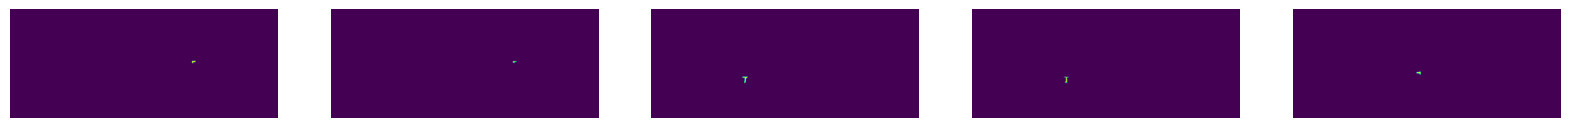

In [12]:
# mask_listの中身を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mask_list[i][0])
    plt.axis("off")
plt.show()

In [13]:
train_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x4

In [14]:
len(train_list)

394

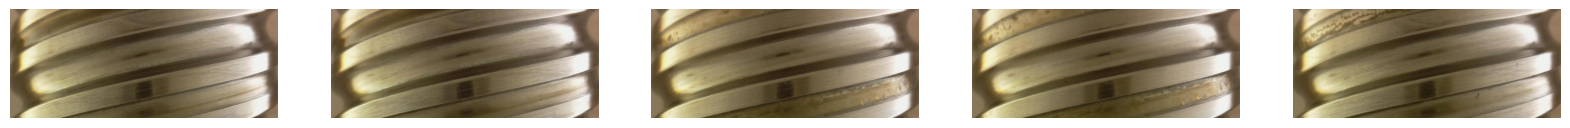

In [15]:
# train_listの中身を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_list[i])
    plt.axis("off")
plt.show()

In [16]:
# train_list[0]のshapeを確認
train_list[0].size

(1130, 460)

In [17]:
# mask_list[0]のshapeを確認
mask_list[0][0].size

(1130, 460)

In [18]:
# train_listとmask_listを使用してsegmentation_models_pytorchを使用してセグメンテーションを行う
# データセットクラスを作成
class SegmentationDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        mask = self.mask_list[idx][0]
        if self.transform:
            transformed = self.transform(image=np.array(img), mask=np.array(mask))
            img = transformed["image"]
            mask = transformed["mask"]
        return img, mask


# データセットを学習用とテスト用に分割
train_img_list, val_img_list, train_mask_list, val_mask_list = train_test_split(
    train_list, mask_list, test_size=0.2, random_state=42
)

# 画像とマスクの前処理を定義、正規化はA.Normalize()を使用
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomResizedCrop(256, 256, scale=(0.8, 1.0)),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transform = A.Compose([A.Resize(256, 256), A.Normalize(), ToTensorV2()])

# データセットを作成
train_dataset = SegmentationDataset(
    train_img_list, train_mask_list, transform=train_transform
)
val_dataset = SegmentationDataset(val_img_list, val_mask_list, transform=val_transform)

# データセットをDataLoaderに変換
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルを定義
model = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(
    device
)

# 損失関数を定義
criterion = nn.BCEWithLogitsLoss()

# 最適化手法を定義
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 学習率スケジューラを定義
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3, verbose=True, eps=1e-6
)

In [19]:
len(train_dataset)

315

In [20]:
len(val_dataset)

79

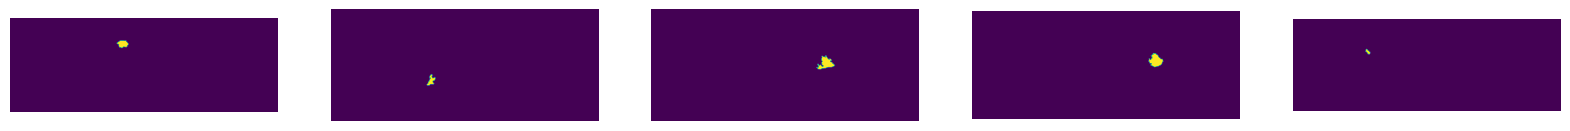

In [21]:
# train_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = train_img_list[i]
    mask = train_mask_list[i][0]
    # plt.imshow(img)
    plt.imshow(mask)
    plt.axis("off")
plt.show()

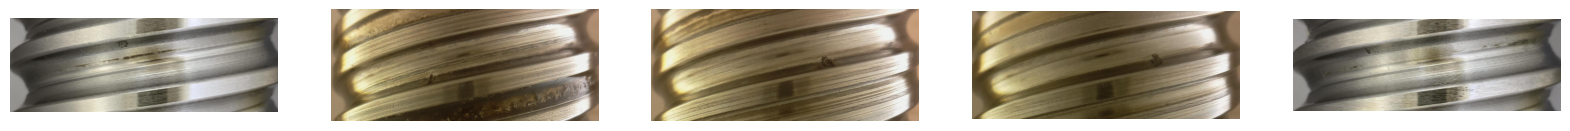

In [22]:
# train_img_listの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = train_img_list[i]
    mask = train_mask_list[i][0]
    plt.imshow(img)
    # plt.imshow(mask)
    plt.axis("off")
plt.show()

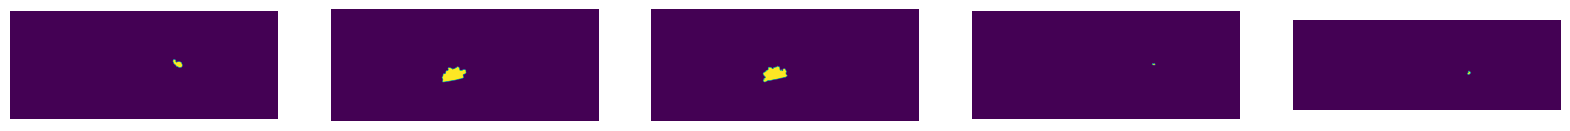

In [23]:
# val_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    # plt.imshow(img)
    plt.imshow(mask)
    plt.axis("off")
plt.show()

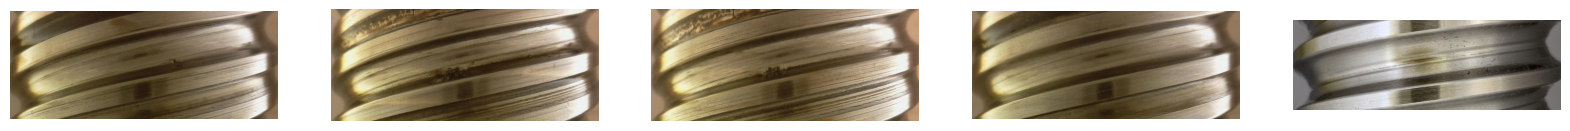

In [24]:
# val_img_listの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    plt.imshow(img)
    # plt.imshow(mask)
    plt.axis("off")
plt.show()

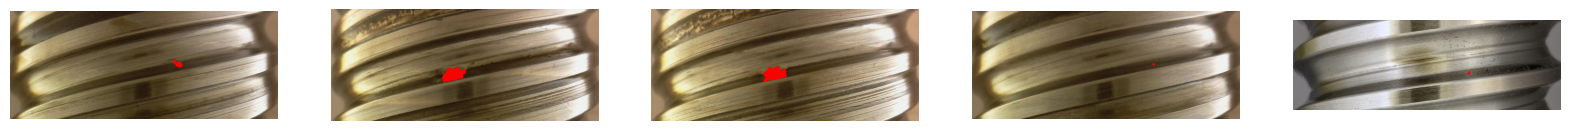

In [25]:
# val_img_list, val_mask_listの画像とマスクを重ねて5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    img = np.array(img)
    mask = np.array(mask)
    img[mask == 1] = [255, 0, 0]
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [26]:
# テストデータは使用せずに学習
num_epochs = 30
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks in tqdm(train_loader):
        inputs = inputs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            # ターゲットの形状を [バッチサイズ, 高さ, 幅] から [バッチサイズ, チャンネル数, 高さ, 幅] に変更する
            masks = masks.unsqueeze(1).type(
                torch.float32
            )  # 1チャンネル目に次元を追加、BCEWithLogitsLoss はFloat型のターゲットを期待する
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {train_loss}")

    model.eval()
    running_loss = 0.0
    for inputs, masks in tqdm(val_loader):
        inputs = inputs.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            masks = masks.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, masks)
        running_loss += loss.item()
    val_loss = running_loss / len(val_loader)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {val_loss}")
    scheduler.step(val_loss)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 0.7471300706267356


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 0.7018545031547546


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.5541624821722507


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.5086022853851319


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.4177203685045242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.3739462524652481


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.31342803388834


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.2964053779840469


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.25366067588329316


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.23827085494995118


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.21330640874803067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.2063196301460266


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.18677792325615883


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.17843201607465745


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.16563804745674132


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.15900350213050843


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.1470408972352743


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.14032529592514037


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.1324531953781843


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.12361849024891854


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.1202859953045845


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.11426233127713203


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.10887551810592414


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.10343412682414055


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.09838651027530432


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.09369242936372757


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.09015835952013732


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.08594458028674126


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.08508043568581343


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.07903107330203056


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.07643017787486314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.07015680819749832


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.07004729956388474


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.06406751573085785


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.06451021758839488


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.058621804043650624


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.05968505991622806


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.05460877381265163


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.05509575642645359


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.05070830434560776


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.05105662727728486


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.045731059089303014


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.04742723936215043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.04291476495563984


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.04435495026409626


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.0405876524746418


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.04110947009176016


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.03807248584926128


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.038371906243264677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.03477645255625248


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.03628315543755889


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.033247006684541704


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.03411792665719986


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.03180707897990942


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.03227089801803231


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.0295105354860425


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.030579685559496285


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.028308021649718285


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.028701651282608508


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.02622126378118992


  0%|          | 0/10 [00:00<?, ?it/s]

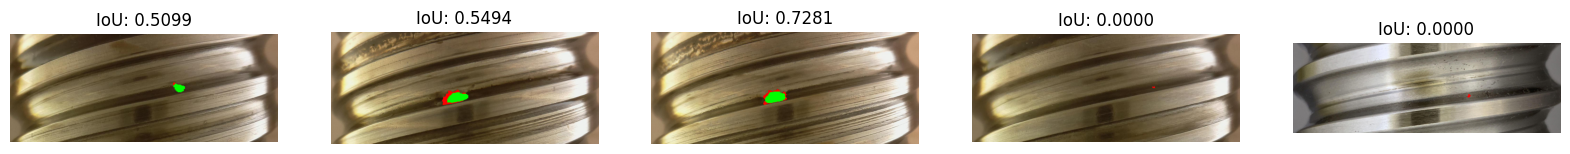

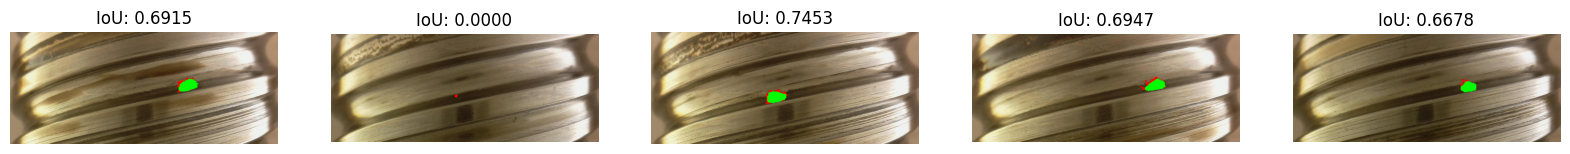

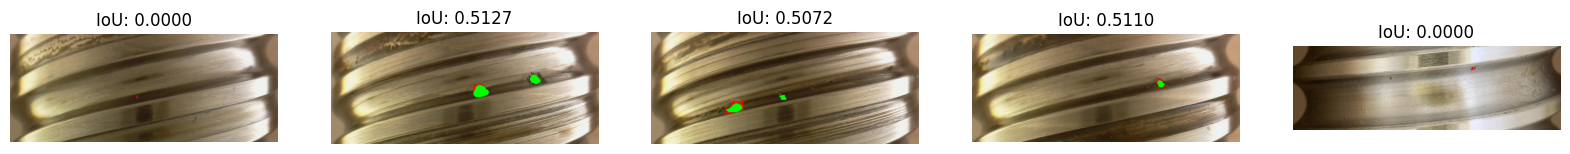

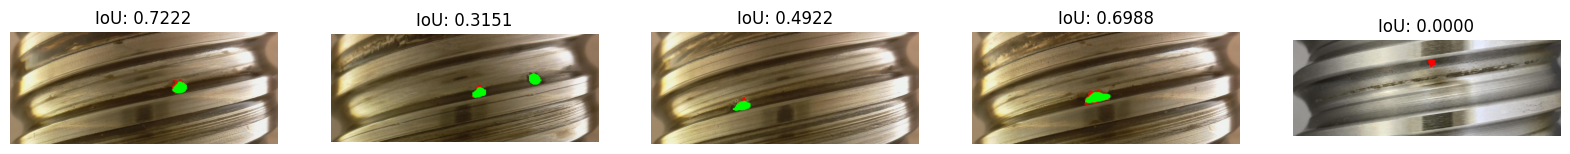

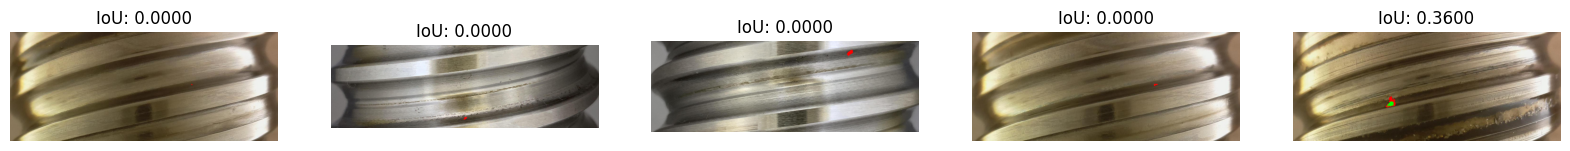

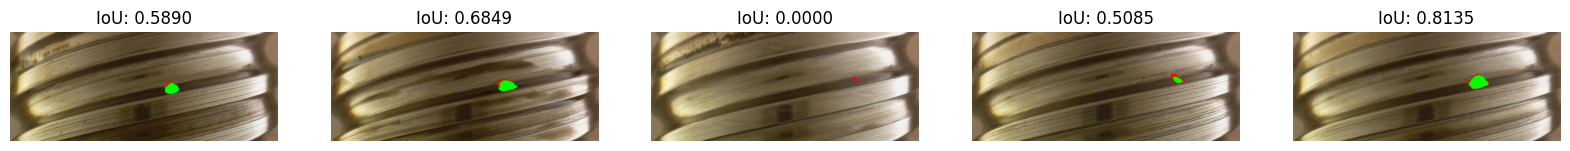

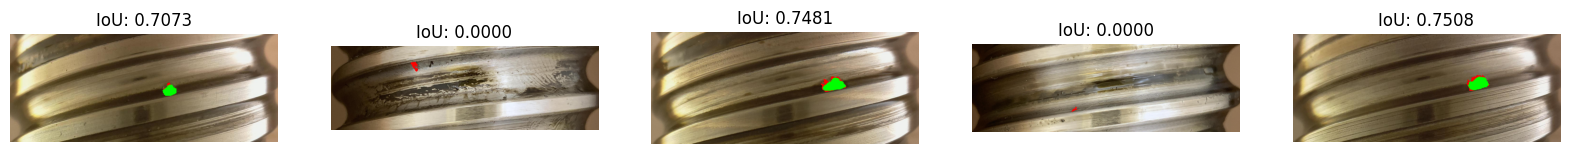

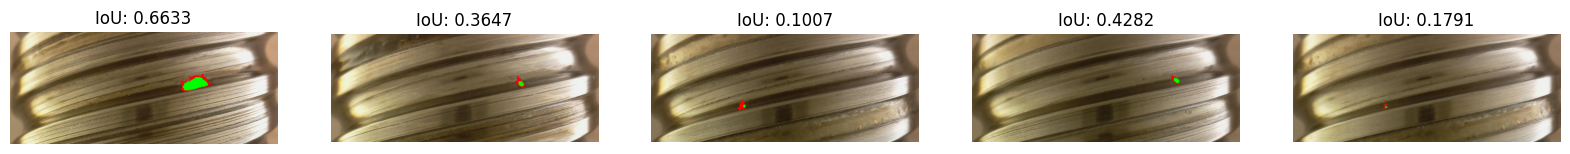

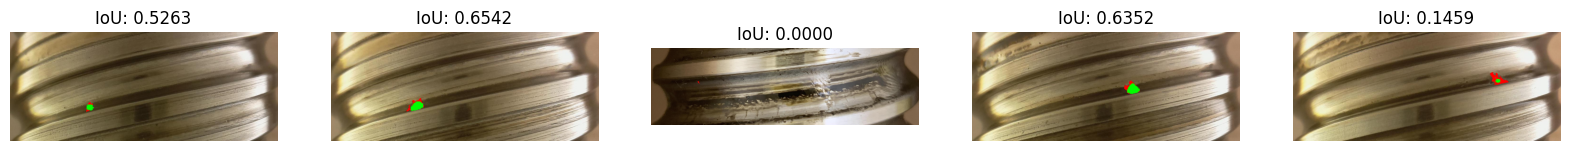

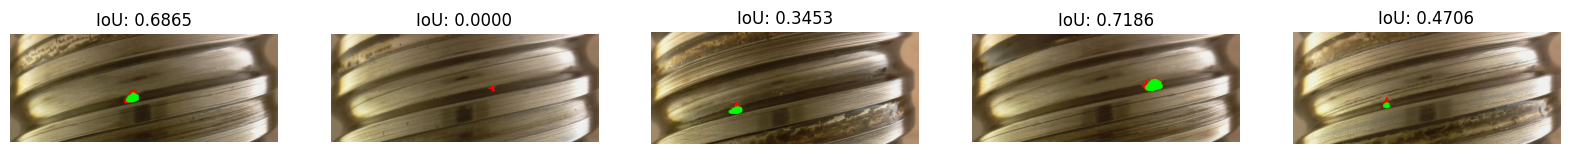

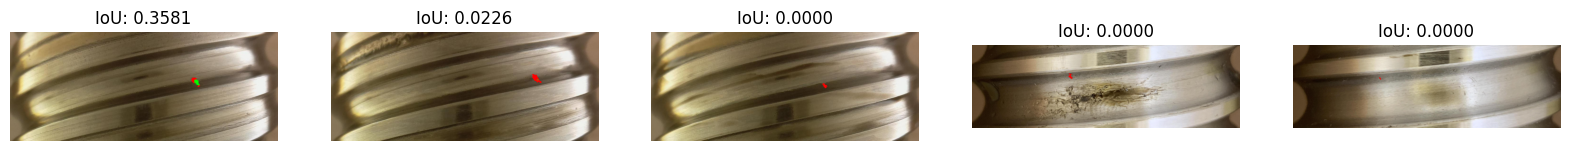

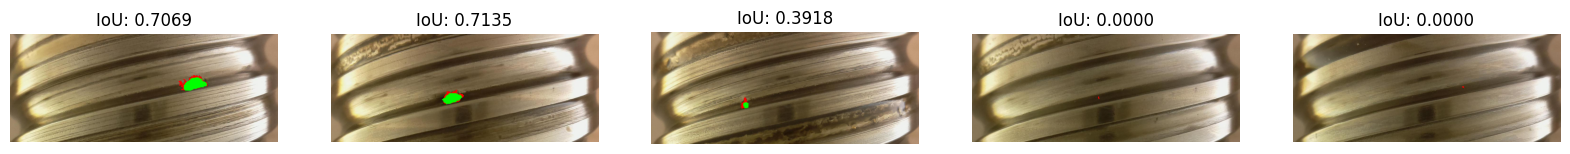

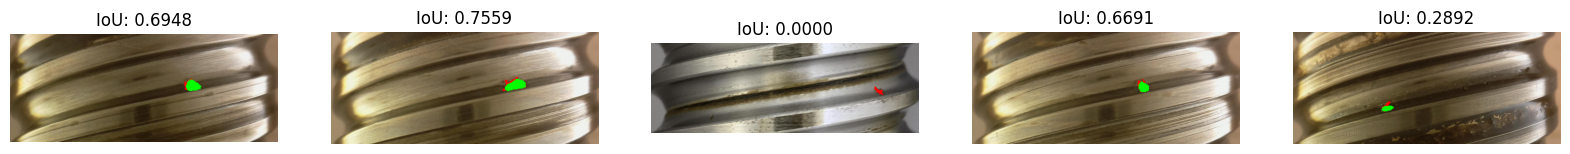

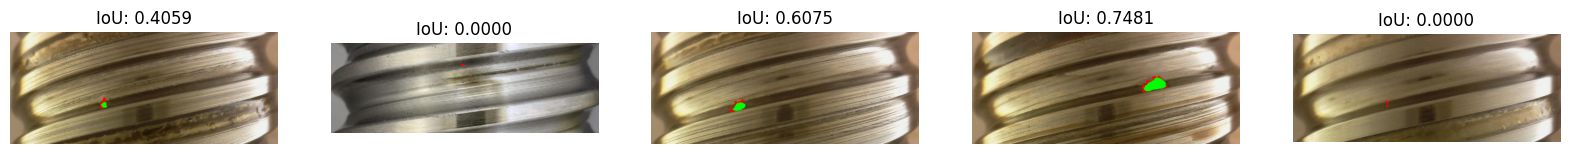

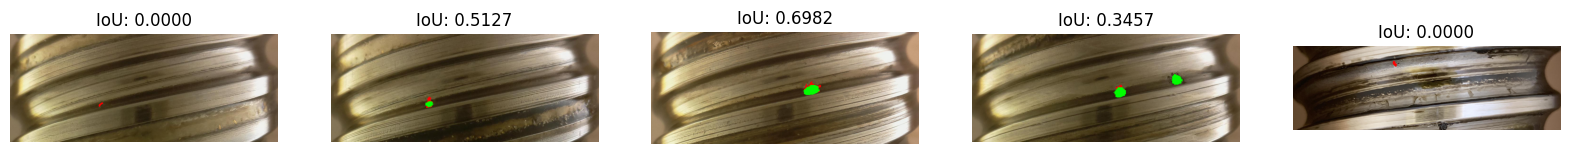

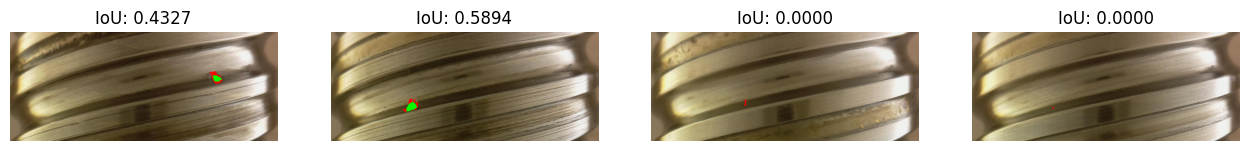

In [27]:
# モデルの評価モード
model.eval()
outputs_list = []

# val_loader からのデータに対してモデルの予測を収集
for img, mask in tqdm(val_loader):
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
    outputs_list.extend(outputs.cpu().numpy())

iou_list = []

# 5枚ごとに分割して表示
num_images = len(val_img_list)
num_batches = (num_images + 4) // 5  # 5枚ずつ分割したときのバッチ数

for batch_idx in range(num_batches):
    start_idx = batch_idx * 5
    end_idx = min(start_idx + 5, num_images)
    plt.figure(figsize=(20, 10))
    for i in range(start_idx, end_idx):
        plt.subplot(1, 5, i - start_idx + 1)
        img = val_img_list[i]
        mask = val_mask_list[i][0]
        
        # imgとmaskをNumPy配列に変換
        img = np.array(img)
        mask = np.array(mask)
        
        # マスクされた部分を赤色にする
        img[mask == 1] = [255, 0, 0]
        
        # モデルからの予測結果を取得
        pred = outputs_list[i]
        pred = np.squeeze(pred)  # バッチ次元を除く
        if pred.ndim == 3:
            pred = pred[0]  # チャネル次元を除く（最初のチャネルを使用）
        
        # predをimgのサイズにリサイズする
        pred_resized = cv2.resize(
            pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
        )
        
        # 予測マスクを元の画像に適用
        img[pred_resized > 0.5] = [0, 255, 0]  # 予測された部分を緑色で表示
        
        # IoUの計算
        mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        pred_resized = pred_resized > 0.5
        mask_resized = mask_resized > 0.5
        intersection = np.logical_and(pred_resized, mask_resized)
        union = np.logical_or(pred_resized, mask_resized)
        iou = np.sum(intersection) / np.sum(union)
        iou_list.append(iou)

        plt.imshow(img)
        plt.title(f'IoU: {iou:.4f}')
        plt.axis("off")

    plt.show()

In [28]:
# IoUの平均値を計算
iou_mean = np.mean(iou_list)
print(f"Mean IoU: {iou_mean:.4f}")

Mean IoU: 0.3591
